In [2]:
import pandas as pd
from s3fs import S3FileSystem
import os


def load_credentials(access_key_file, secret_key_file):
    """
    Load access key and secret key from text files

    Parameters:
    access_key_file (str): Path to file containing access key
    secret_key_file (str): Path to file containing secret key

    Returns:
    tuple: (access_key, secret_key)
    """
    try:
        with open(access_key_file, "r") as f:
            access_key = f.read().strip()

        with open(secret_key_file, "r") as f:
            secret_key = f.read().strip()

        return access_key, secret_key
    except FileNotFoundError as e:
        print(f"Error: Credential file not found - {e}")
        return None, None
    except Exception as e:
        print(f"Error reading credential files: {e}")
        return None, None


def load_parquet_files_from_scaleway_s3(
    bucket_name, prefix="", region="fr-par", country=None
):
    """
    Load parquet files from Scaleway S3 object store and combine them into a single DataFrame

    Parameters:
    bucket_name (str): Name of the S3 bucket
    prefix (str): Prefix to filter files (optional)
    region (str): Scaleway region (default: fr-par for Paris)
    country (str): Country code to filter files (optional)

    Returns:
    pandas.DataFrame: Combined DataFrame
    """

    # Load credentials from files
    access_key_file = "../../secrets/scw_bucket.txt"
    secret_key_file = "../../secrets/scw_bucket_secret.txt"

    access_key, secret_key = load_credentials(access_key_file, secret_key_file)

    if not access_key or not secret_key:
        print("Error: Could not load credentials from files")
        return pd.DataFrame()

    # Set up S3 filesystem with Scaleway credentials
    s3 = S3FileSystem(
        key=access_key, secret=secret_key, endpoint_url=f"https://s3.{region}.scw.cloud"
    )

    # Handle country parameter
    if country and country != "france":
        # Set prefix to country filter
        search_prefix = f"country={country}"
        if prefix:
            search_prefix = f"{search_prefix}/{prefix}"
    else:
        search_prefix = prefix

    # Construct the path to search for parquet files recursively
    if search_prefix:
        search_path = f"{bucket_name}/{search_prefix}/**/*.parquet"
    else:
        search_path = f"{bucket_name}/**/*.parquet"

    try:
        # List all parquet files recursively (including subfolders)
        files = s3.glob(search_path)
        if not search_prefix:
            files = [file for file in files if "country" not in file]


        if not files:
            print("No parquet files found!")
            return pd.DataFrame()

        print(f"Found {len(files)} parquet files:")
        for file in files:
            print(f"  - {file}")

        # Load and combine all parquet files
        dataframes = []
        for file in files:
            try:
                with s3.open(file, "rb") as f:
                    df = pd.read_parquet(f)
                    dataframes.append(df)
                    print(f"Loaded {len(df)} rows from {file}")
            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue

        if not dataframes:
            print("No files were successfully loaded!")
            return pd.DataFrame()

        # Combine all DataFrames
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(
            f"\nSuccessfully combined {len(dataframes)} files into DataFrame with shape: {combined_df.shape}"
        )

        return combined_df

    except Exception as e:
        print(f"Error accessing S3: {e}")
        return pd.DataFrame()


In [3]:
# Configuration
BUCKET_NAME = "test-bucket-mediatree"
PREFIX = ""  # Optional: filter files with specific prefix
REGION = "fr-par"  # Scaleway region

# Example usage with different country parameters
print("Loading parquet files from Scaleway S3...")

# Load data for France (default behavior - no country prefix)
print("\n=== Loading data for France ===")
df_france = load_parquet_files_from_scaleway_s3(
    bucket_name=BUCKET_NAME, prefix=PREFIX, region=REGION, country="france"
)

# Load data for a specific country
print("\n=== Loading data for Brazil ===")
df_brazil = load_parquet_files_from_scaleway_s3(
    bucket_name=BUCKET_NAME, prefix=PREFIX, region=REGION, country="brazil"
)

# Print column names for France data
if not df_france.empty:
    print("\n=== Column names for France data ===")
    for i, col in enumerate(df_france.columns):
        print(f"  {i+1}. {col}")

    print(f"\nTotal columns for France: {len(df_france.columns)}")
    print(f"DataFrame shape for France: {df_france.shape}")

# Print column names for Brazil data
if not df_brazil.empty:
    print("\n=== Column names for Brazil data ===")
    for i, col in enumerate(df_brazil.columns):
        print(f"  {i+1}. {col}")

    print(f"\nTotal columns for Brazil: {len(df_brazil.columns)}")
    print(f"DataFrame shape for Brazil: {df_brazil.shape}")


Loading parquet files from Scaleway S3...

=== Loading data for France ===
Found 540 parquet files:
  - test-bucket-mediatree/year=2025/month=8/day=10/channel=arte/4fa99b3e14384383b9294bf42c05ac23-0.parquet
  - test-bucket-mediatree/year=2025/month=8/day=10/channel=bfmtv/4ea83c7e14534dccbb1ed962906e43f8-0.parquet
  - test-bucket-mediatree/year=2025/month=8/day=10/channel=europe1/d86d68c19fbb4e6fb70e8b2052e879e2-0.parquet
  - test-bucket-mediatree/year=2025/month=8/day=10/channel=fr3-idf/0cbea0b71e8e4193803e9adcfe5f6cfc-0.parquet
  - test-bucket-mediatree/year=2025/month=8/day=10/channel=france-culture/6724a2d49ae742f68ec1982c4009a942-0.parquet
  - test-bucket-mediatree/year=2025/month=8/day=10/channel=france-info/e6e0c5f28ee1481582954d1b9e517088-0.parquet
  - test-bucket-mediatree/year=2025/month=8/day=10/channel=france-inter/61fc5edf62ec44f9b2b4e04587e41e5c-0.parquet
  - test-bucket-mediatree/year=2025/month=8/day=10/channel=france2/29021516fb684b9dbe4e9488f11beabf-0.parquet
  - test-

In [ ]:
df_brazil["duration"] = 2
df_france["duration"] = 2


In [5]:
df_brazil["date"] = pd.to_datetime(df_brazil.start).dt.date
df_france["date"] = pd.to_datetime(df_france.start).dt.date

In [6]:
df_france

,plaintext,srt,channel_name,channel_title,channel_radio,start,channel_program,channel_program_type,program_metadata_id,country,duration,date
0,procédures d' autorisation les militants écolo...,"[{'cts_in_ms': 1754848679004, 'duration_ms': 3...",arte,Arte,False,2025-08-10 19:58:00+02:00,JT,Information - Journal,a66de468be7d4b890263861475b1511fe543cf090129b9...,france,2,2025-08-10
1,du bigoudis électrique <unk> depuis quand es à...,"[{'cts_in_ms': 1754847839052, 'duration_ms': 6...",arte,Arte,False,2025-08-10 19:44:00+02:00,JT,Information - Journal,a66de468be7d4b890263861475b1511fe543cf090129b9...,france,2,2025-08-10
2,non volants pour les familles des quarante neu...,"[{'cts_in_ms': 1754848079010, 'duration_ms': 3...",arte,Arte,False,2025-08-10 19:48:00+02:00,JT,Information - Journal,a66de468be7d4b890263861475b1511fe543cf090129b9...,france,2,2025-08-10
3,plusieurs pays européens appelle à renforcer l...,"[{'cts_in_ms': 1754848319024, 'duration_ms': 3...",arte,Arte,False,2025-08-10 19:52:00+02:00,JT,Information - Journal,a66de468be7d4b890263861475b1511fe543cf090129b9...,france,2,2025-08-10
4,et coupe au carré de lumière ciselés depuis pl...,"[{'cts_in_ms': 1754849279000, 'duration_ms': 4...",arte,Arte,False,2025-08-10 20:08:00+02:00,JT,Information - Journal,a66de468be7d4b890263861475b1511fe543cf090129b9...,france,2,2025-08-10
...,...,...,...,...,...,...,...,...,...,...,...,...
148277,perturbation qui arrive dans la journée de jeu...,"[{'cts_in_ms': 1756749447035, 'duration_ms': 3...",tf1,TF1,False,2025-09-01 19:56:00+02:00,JT 20h + météo,Information - Journal,7e42c12bf08f375772d9738118b6b511f0e7417f0123f2...,france,2,2025-09-01
148278,est levée dans tous les départements dans les ...,"[{'cts_in_ms': 1756749719024, 'duration_ms': 3...",tf1,TF1,False,2025-09-01 20:02:00+02:00,JT 20h + météo,Information - Journal,7e42c12bf08f375772d9738118b6b511f0e7417f0123f2...,france,2,2025-09-01
148279,ensemble même si son limitant cinq ça leur per...,"[{'cts_in_ms': 1756750079004, 'duration_ms': 3...",tf1,TF1,False,2025-09-01 20:08:00+02:00,JT 20h + météo,Information - Journal,7e42c12bf08f375772d9738118b6b511f0e7417f0123f2...,france,2,2025-09-01
148280,de cocaïne a été multiplié par neuf conséquenc...,"[{'cts_in_ms': 1756750919000, 'duration_ms': 4...",tf1,TF1,False,2025-09-01 20:22:00+02:00,JT 20h + météo,Information - Journal,7e42c12bf08f375772d9738118b6b511f0e7417f0123f2...,france,2,2025-09-01


In [9]:
df_brazil_grouped = df_brazil.groupby(["date", "channel_name"]).agg(
    total_sum_minutes=("duration", sum)
)
df_france_grouped = df_france.groupby(["date", "channel_name"]).agg(
    total_sum_minutes=("duration", sum)
)

/var/folders/_y/jjyv0bm5597_x15dvpxnsmrc0000gn/T/ipykernel_65673/3578378749.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_brazil_grouped = df_brazil.groupby(["date", "channel_name"]).agg(
/var/folders/_y/jjyv0bm5597_x15dvpxnsmrc0000gn/T/ipykernel_65673/3578378749.py:4: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_france_grouped = df_france.groupby(["date", "channel_name"]).agg(


In [8]:
df_brazil_grouped.head()

total_sum_minutes
date       channel_name channel_program                   
2025-08-03 cnnbrasil                                    10
           jovempan                                     64
           sbt                                          28
           tvglobo                                     150
           tvrecord                                     40

In [10]:
df_france_grouped.head()

total_sum_minutes
date       channel_name                     
2025-08-03 arte                           88
           bfmtv                        1028
           europe1                       300
           fr3-idf                       190
           france-culture                188

In [158]:
import sys

sys.path.append("./../../")
import pandas as pd
from datetime import datetime, timedelta
from collections import defaultdict

# Import the channel programs data
from quotaclimat.data_processing.mediatree.i8n.brazil.channel_program import channels_programs_brazil
from quotaclimat.data_processing.mediatree.i8n.france.channel_program import channels_programs_france



def calculate_program_time_by_channel_and_date(
    channels_programs,
    start_date_str="2025-08-02", 
    end_date_str="2025-09-01"
):
    """
    Calculate total program time per channel per day from start_date to end_date

    Parameters:
    start_date_str (str): Start date in YYYY-MM-DD format
    end_date_str (str): End date in YYYY-MM-DD format

    Returns:
    pandas.DataFrame: DataFrame with columns ['date', 'channel_name', 'total_minutes']
    """

    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    print(start_date)
    # Create date range
    date_range = []
    current_date = start_date
    while current_date <= end_date:
        date_range.append(current_date)
        current_date += timedelta(days=1)

    # Initialize result list
    results = []

    # Process each program
    for program in channels_programs:
        channel_name = program["channel_name"]
        start_time_str = program["start"]
        end_time_str = program["end"]
        weekday_type = program["weekday"]
        grid_start_str = program["program_grid_start"]
        grid_end_str = program["program_grid_end"]

        # Convert time strings to datetime objects
        start_time = datetime.strptime(start_time_str, "%H:%M")
        end_time = datetime.strptime(end_time_str, "%H:%M")

        # Handle overnight programs (end time < start time)
        if end_time < start_time:
            end_time += timedelta(days=1)

        # Calculate program duration in minutes
        duration = (end_time - start_time).total_seconds() / 60

        # Convert grid dates to datetime objects
        grid_start = datetime.strptime(grid_start_str, "%Y-%m-%d")
        if grid_end_str:
            grid_end = datetime.strptime(grid_end_str, "%Y-%m-%d")
        else:
            # If no end date, assume it's valid for a long time (set to end of period)
            grid_end = end_date + timedelta(days=30)  # Extend beyond our period

        # Process each day in the date range
        for date in date_range:
            # Check if this program is active on this date
            if date < grid_start or date > grid_end:
                continue

            # Check if this day matches the weekday type
            day_of_week = date.weekday()  

            if weekday_type == "weekday" and day_of_week in [0, 1, 2, 3, 4]:
                # It's a weekday program on a weekday
                pass
            elif weekday_type == "weekend" and day_of_week in [5, 6]:
                # It's a weekend program on a weekend
                pass
            elif weekday_type == "*":
                # * occurs every day
                pass
            elif weekday_type == str(day_of_week):
                pass
            else:
                # This program doesn't run on this day
                continue

            # Add to results
            date_str = date.strftime("%Y-%m-%d")
            results.append(
                {
                    "date": date_str,
                    "channel_name": channel_name,
                    "total_minutes": duration,
                }
            )

    # Create DataFrame
    df = pd.DataFrame(results)

    # Group by date and channel, sum the minutes
    if not df.empty:
        df = df.groupby(["date", "channel_name"], as_index=False)["total_minutes"].sum()

    return df


def get_channel_programs_summary(
    channels_programs,
    start_date_str="2025-08-02", 
    end_date_str="2025-09-01"
):
    """
    Get a summary DataFrame with total program time grouped by channel_name and date

    Returns:
    pandas.DataFrame: DataFrame with columns ['date', 'channel_name', 'total_minutes']
    """

    print(f"Calculating program time from {start_date_str} to {end_date_str}")

    df = calculate_program_time_by_channel_and_date(
        channels_programs,
        start_date_str=start_date_str, 
        end_date_str=end_date_str,
    )

    # Sort by date and channel for better readability
    df = df.sort_values(["date", "channel_name"]).reset_index(drop=True)

    return df


In [159]:
result_df_brazil = get_channel_programs_summary(
    channels_programs_brazil,
    start_date_str="2025-08-03", 
    end_date_str="2025-09-01",
)


result_df_france = get_channel_programs_summary(
    channels_programs_france,
    start_date_str="2025-08-03", 
    end_date_str="2025-09-01",
)


Calculating program time from 2025-08-03 to 2025-09-01
2025-08-03 00:00:00
Calculating program time from 2025-08-03 to 2025-09-01
2025-08-03 00:00:00


In [160]:
display(result_df_brazil.sort_values(["date", "channel_name", "total_minutes"]).head())
display(result_df_france.sort_values(["date", "channel_name", "total_minutes"]).head())

,date,channel_name,total_minutes
0,2025-08-03,cnnbrasil,75.0
1,2025-08-03,jovempan,60.0
2,2025-08-03,redebandeirantes,30.0
3,2025-08-03,sbt,180.0
4,2025-08-03,tvglobo,415.0


,date,channel_name,total_minutes
0,2025-08-03,arte,65.0
1,2025-08-03,bfmtv,1020.0
2,2025-08-03,europe1,270.0
3,2025-08-03,fr3-idf,150.0
4,2025-08-03,france-culture,190.0


In [161]:
result_df_france.channel_name.unique()

array(['arte', 'bfmtv', 'europe1', 'fr3-idf', 'france-culture',
       'france-info', 'france-inter', 'france2', 'france24',
       'franceinfotv', 'itele', 'lci', 'm6', 'rfi', 'rmc', 'rtl',
       'sud-radio', 'tf1', 'd8'], dtype=object)

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates

def compare_channel_programs_with_scaleway_data(df_scaleway_grouped, df_channel_program):
    """
    Compare channel programs data with Brazil dataframe and plot the differences
    
    Parameters:
    df_scaleway_grouped (pandas.DataFrame): DataFrame with date, channel_name, total_sum_minutes
    channels_programs (list): List of channel program records
    
    Returns:
    pandas.DataFrame: DataFrame with comparison results
    """
        
    # Merge with actual data
    comparison_df = create_comparison_dataframe(df_scaleway_grouped, df_channel_program)
    
    # Plot the comparison
    plot_comparison(comparison_df)
    plot_comparison_clean(comparison_df)
    
    return comparison_df


def create_comparison_dataframe(df_scaleway_grouped, df_theoretical):
    """
    Create comparison dataframe with actual vs theoretical minutes
    
    Parameters:
    df_scaleway_grouped (pandas.DataFrame): Actual data from Brazil
    df_theoretical (pandas.DataFrame): Theoretical program time
    
    Returns:
    pandas.DataFrame: Comparison dataframe
    """
    df_scaleway_grouped = df_scaleway_grouped.reset_index()
    df_scaleway_grouped.date = pd.to_datetime(df_scaleway_grouped.date)
    df_theoretical.date = pd.to_datetime(df_theoretical.date)
    print(df_theoretical.shape)
    print(df_theoretical.columns)
    print(df_scaleway_grouped.columns)
    # Merge the dataframes on date and channel_name

    # comparison_df = pd.concat(
    #     [
    #         df_scaleway_grouped,
    #         df_theoretical.set_index(['date', 'channel_name'])
    #     ],
    #     axis=1
    # )
    comparison_df = df_scaleway_grouped.merge(
        df_theoretical, 
        on=['date', 'channel_name'], 
        how='outer', 
        suffixes=('_actual', '_theoretical')
    )

    comparison_df = comparison_df.fillna(0)
    print(comparison_df.head())
        
    # Calculate error (difference between actual and theoretical)
    comparison_df['error'] = comparison_df['total_sum_minutes'] - comparison_df['total_minutes']
    comparison_df['perc_error'] = 100 * comparison_df['error'] / comparison_df['total_minutes']
    return comparison_df.reset_index()

def plot_comparison(comparison_df):
    """
    Plot the comparison as a line graph
    
    Parameters:
    comparison_df (pandas.DataFrame): Comparison dataframe with date, channel_name, error
    """
    
    if comparison_df.empty:
        print("No data to plot")
        return
    
    # Convert date string to datetime for proper plotting
    comparison_df['date'] = pd.to_datetime(comparison_df['date'])
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Get unique channels
    channels = comparison_df['channel_name'].unique()
    
    # Plot each channel with different color
    colors = plt.cm.Set1(np.linspace(0, 1, len(channels)))
    
    for i, channel in enumerate(channels):
        channel_data = comparison_df[comparison_df['channel_name'] == channel].sort_values('date')
        
        if not channel_data.empty:
            plt.plot(channel_data['date'], 
                    channel_data['perc_error'], 
                    marker='o', 
                    label=channel, 
                    linewidth=2, 
                    markersize=4,
                    color=colors[i % len(colors)])
    
    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('% Error (Actual - Theoretical Minutes) / Theoretical Minutes')
    plt.title('% Difference Between Actual and Theoretical Program Time by Channel')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def plot_comparison_clean(comparison_df):
    """
    Plot the comparison as a clean bar chart with proper date handling
    
    Parameters:
    comparison_df (pandas.DataFrame): Comparison dataframe with date, channel_name, error, perc_error
    """
    
    if comparison_df.empty:
        print("No data to plot")
        return
    
    # Convert date string to datetime for proper plotting
    comparison_df['date'] = pd.to_datetime(comparison_df['date'])
    
    # Create subplots for each channel
    channels = comparison_df['channel_name'].unique()
    
    if len(channels) <= 4:
        fig, axes = plt.subplots(1, len(channels), figsize=(5*len(channels), 6))
        if len(channels) == 1:
            axes = [axes]
    else:
        fig, axes = plt.subplots(2, (len(channels)+1)//2, figsize=(5*len(channels)//2, 10))
        axes = axes.flatten()
    
    # Plot each channel
    for i, channel in enumerate(channels):
        ax = axes[i] if len(channels) <= 4 else axes[i]
        channel_data = comparison_df[comparison_df['channel_name'] == channel].sort_values('date')
        
        if not channel_data.empty:
            bars = ax.bar(range(len(channel_data)), channel_data['perc_error'], 
                         color=plt.cm.Set1(i % plt.cm.Set1.N))
            ax.set_title(f'{channel}')
            ax.set_xlabel('Day Index')
            ax.set_ylabel('% Error (Actual - Theoretical Minutes) / Theoretical Minutes')

            ax.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for j, (bar, value) in enumerate(zip(bars, channel_data['perc_error'])):
                if abs(value) > 0:  # Only show label if value is not zero
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (value/abs(value))*0.5,
                           f'{value:.1f}', ha='center', va='bottom' if value >= 0 else 'top')
    
    # Hide empty subplots
    for i in range(len(channels), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('% Difference Between Actual and Theoretical Program Time by Channel', fontsize=16)
    plt.tight_layout()
    plt.show()



(180, 3)
Index(['date', 'channel_name', 'total_minutes'], dtype='object')
Index(['date', 'channel_name', 'total_sum_minutes'], dtype='object')
        date      channel_name  total_sum_minutes  total_minutes
0 2025-08-03         cnnbrasil               10.0           75.0
1 2025-08-03          jovempan               64.0           60.0
2 2025-08-03  redebandeirantes                0.0           30.0
3 2025-08-03               sbt               28.0          180.0
4 2025-08-03           tvglobo              150.0          415.0


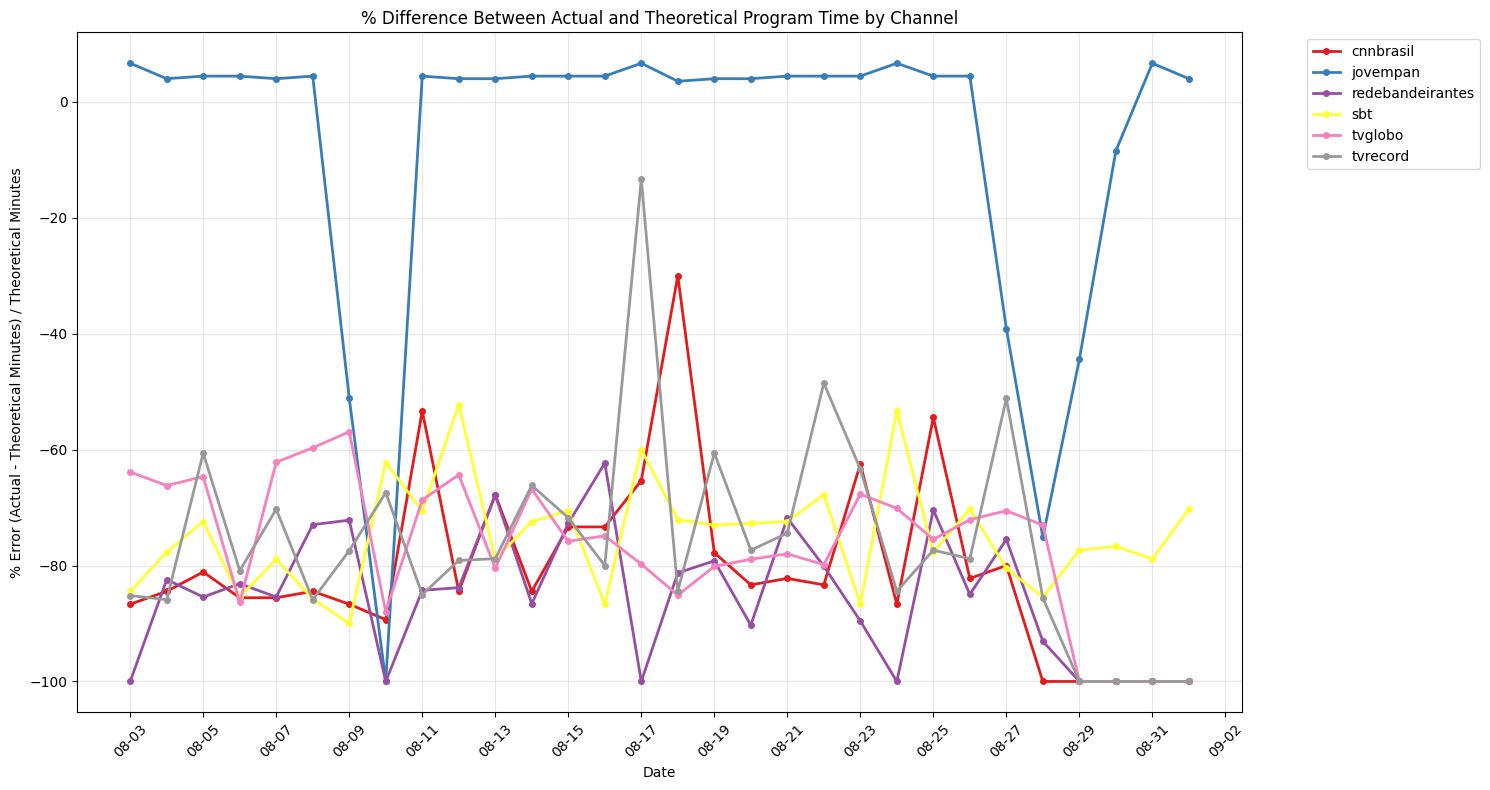

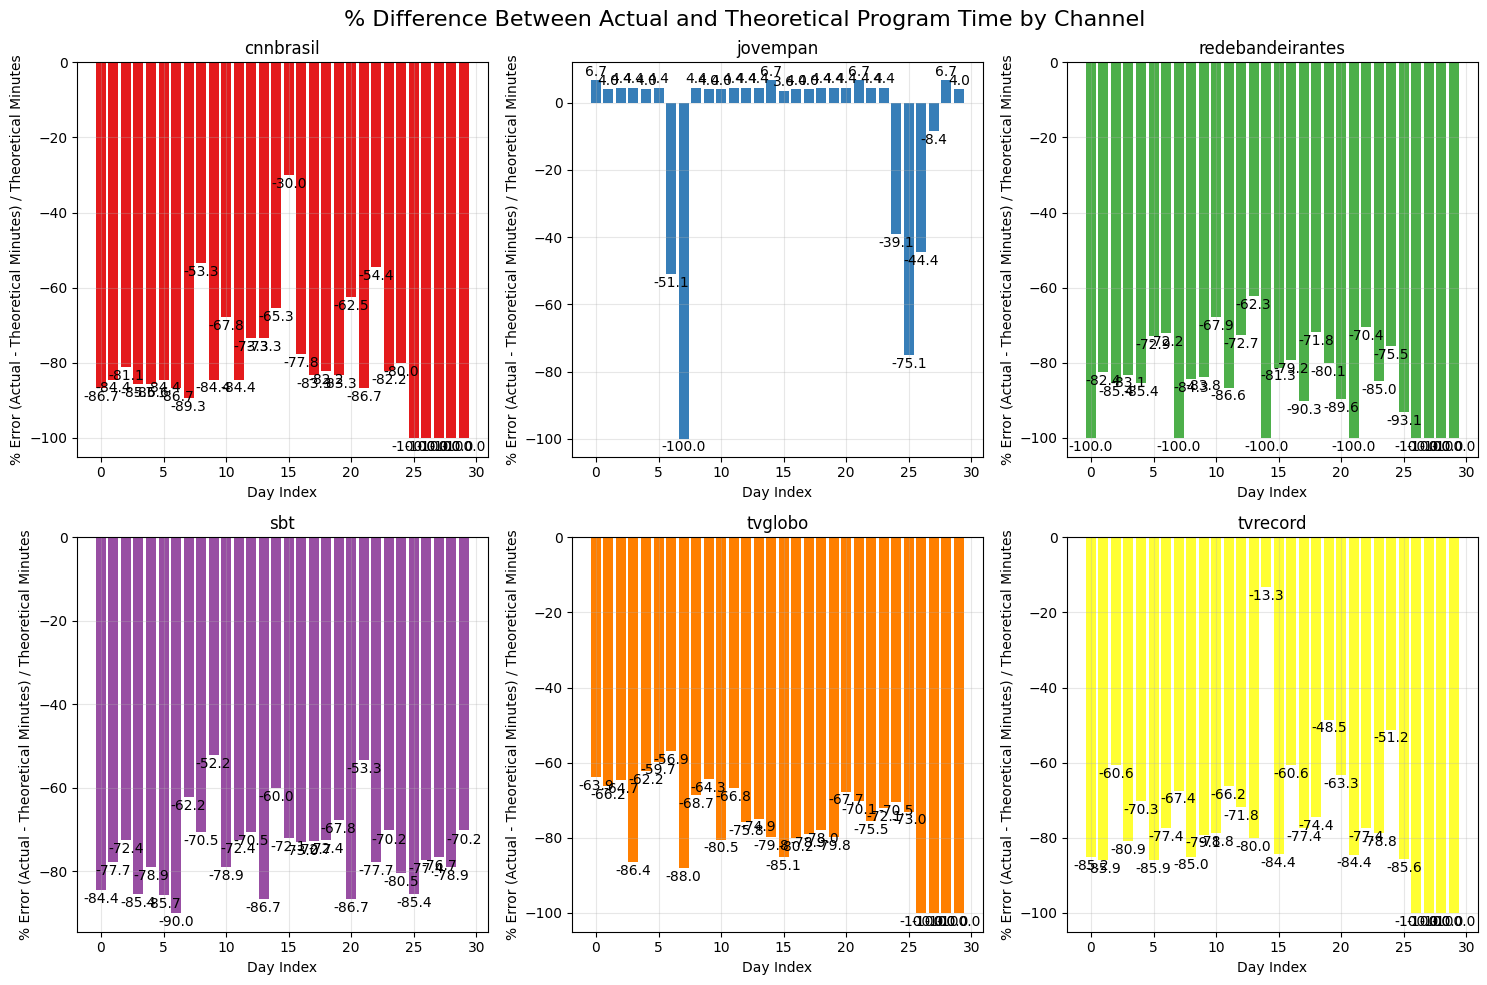

Comparison Results:
   index       date      channel_name  total_sum_minutes  total_minutes  \
0      0 2025-08-03         cnnbrasil               10.0           75.0   
1      1 2025-08-03          jovempan               64.0           60.0   
2      2 2025-08-03  redebandeirantes                0.0           30.0   
3      3 2025-08-03               sbt               28.0          180.0   
4      4 2025-08-03           tvglobo              150.0          415.0   
5      5 2025-08-03          tvrecord               40.0          270.0   
6      6 2025-08-04         cnnbrasil               28.0          180.0   
7      7 2025-08-04          jovempan              468.0          450.0   
8      8 2025-08-04  redebandeirantes              152.0          865.0   
9      9 2025-08-04               sbt              144.0          645.0   

   error  perc_error  
0  -65.0  -86.666667  
1    4.0    6.666667  
2  -30.0 -100.000000  
3 -152.0  -84.444444  
4 -265.0  -63.855422  
5 -230.0  -85.18

In [163]:

comparison_results = compare_channel_programs_with_scaleway_data(
    df_brazil_grouped, 
    result_df_brazil
)

print("Comparison Results:")
print(comparison_results.head(10))

(561, 3)
Index(['date', 'channel_name', 'total_minutes'], dtype='object')
Index(['date', 'channel_name', 'total_sum_minutes'], dtype='object')
        date    channel_name  total_sum_minutes  total_minutes
0 2025-08-03            arte               88.0           65.0
1 2025-08-03           bfmtv             1028.0         1020.0
2 2025-08-03         europe1              300.0          270.0
3 2025-08-03         fr3-idf              190.0          150.0
4 2025-08-03  france-culture              188.0          190.0


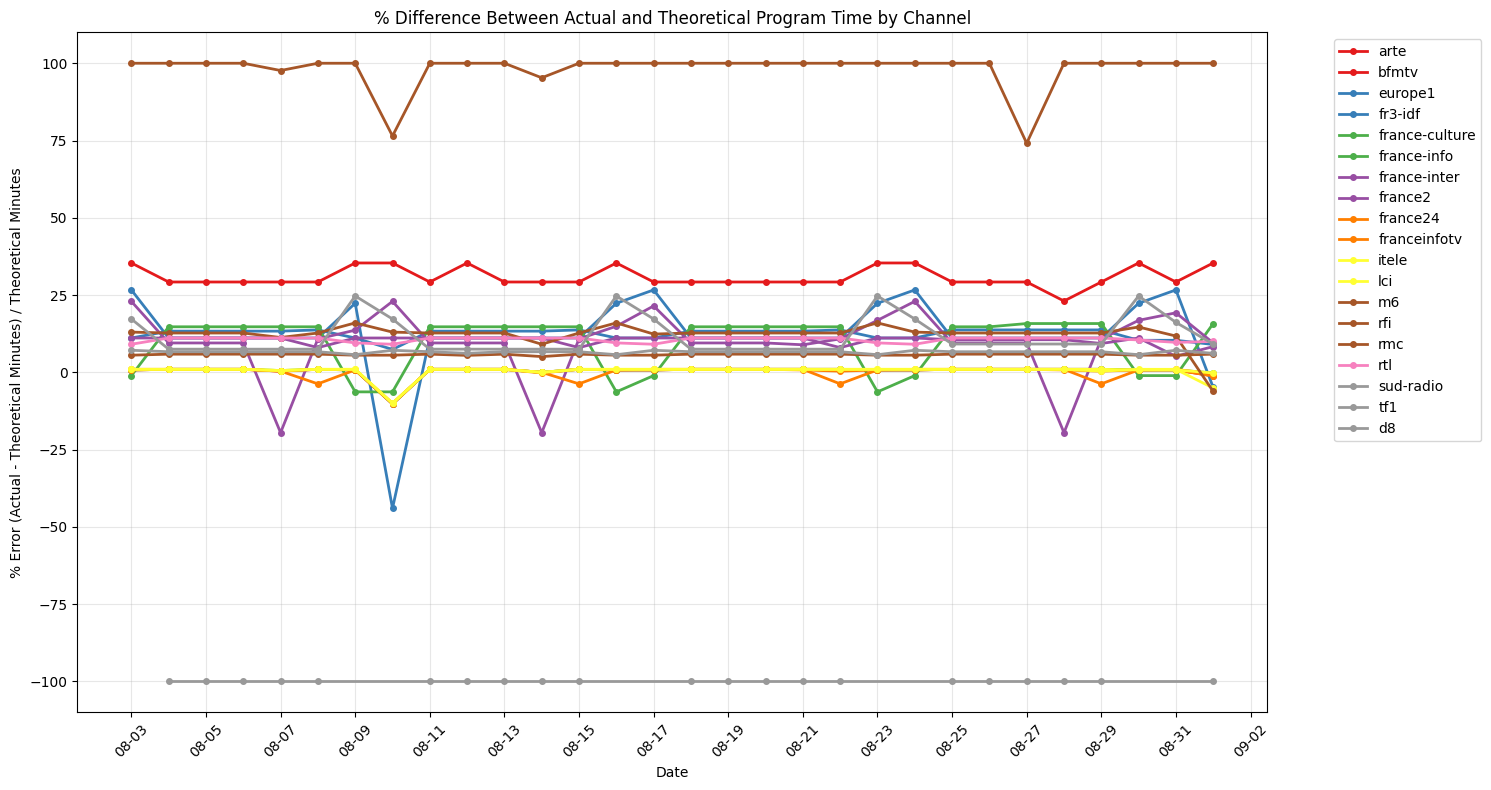

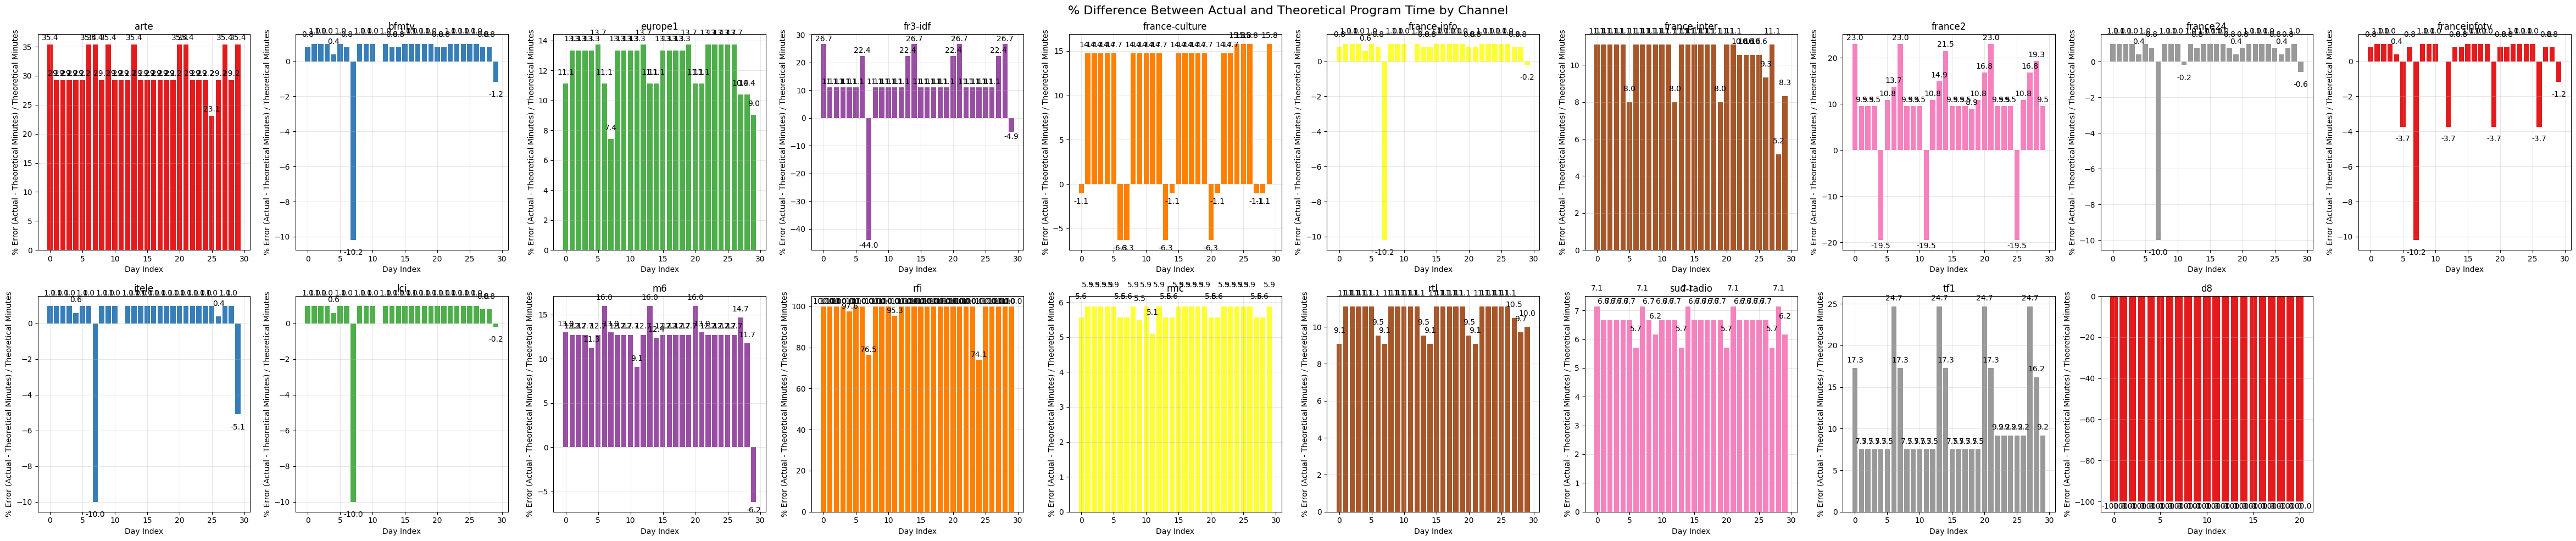

In [164]:

comparison_results = compare_channel_programs_with_scaleway_data(
    df_france_grouped, 
    result_df_france
)


In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_stacked_channel_programs_from_dataframe(df):
    """
    Plot a stacked bar chart from a DataFrame with date, channel_name, and total_minutes
    
    Parameters:
    df (pandas.DataFrame): DataFrame with columns ['date', 'channel_name', 'total_minutes']
    
    Returns:
    pandas.DataFrame: Pivot table used for plotting
    """
    
    if df.empty:
        print("No data to plot")
        return pd.DataFrame()
    
    # Ensure date column is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Create pivot table for stacking
    pivot_df = df.pivot(index='date', columns='channel_name', values='total_minutes')
    
    # Fill NaN values with 0
    pivot_df = pivot_df.fillna(0)
    
    # Sort columns for consistent coloring
    pivot_df = pivot_df.reindex(columns=sorted(pivot_df.columns))
    
    # Create the stacked bar chart
    plt.figure(figsize=(16, 8))
    
    # Plot stacked bar chart
    bars = pivot_df.plot(kind='bar', stacked=True, figsize=(16, 8), width=0.8)
    
    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Total Program Time (Minutes)')
    plt.title('Stacked Program Time by Channel and Date')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Channels")
    plt.grid(True, alpha=0.3)
    
    # Format x-axis dates
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    print("Stacked bar chart created successfully!")
    print(f"Data covers {len(pivot_df)} days")
    print(f"Channels included: {list(pivot_df.columns)}")
    
    return pivot_df

def plot_stacked_channel_programs_from_dataframe_simple(df, values_name="total_minutes"):
    """
    Simplified version that takes a DataFrame and plots the stacked bar chart
    
    Parameters:
    df (pandas.DataFrame): DataFrame with columns ['date', 'channel_name', 'total_minutes']
    
    Returns:
    pandas.DataFrame: Pivot table used for plotting
    """
    
    if df.empty:
        print("No data to plot")
        return pd.DataFrame()
    
    # Ensure date column is datetime and sort by date
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    # Create pivot table for stacking
    pivot_df = df.pivot(index='date', columns='channel_name', values=values_name)
    
    # Fill NaN values with 0
    pivot_df = pivot_df.fillna(0)
    
    # Sort columns for consistent coloring (alphabetically)
    pivot_df = pivot_df.reindex(columns=sorted(pivot_df.columns))
    
    # Create the stacked bar chart
    plt.figure(figsize=(16, 8))
    
    # Plot stacked bar chart
    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(16, 8), width=0.8)
    
    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Total Program Time (Minutes)')
    plt.title('Stacked Program Time by Channel and Date\n(From DataFrame Input)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Channels")
    plt.grid(True, alpha=0.3)
    
    # Format x-axis dates
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    return pivot_df

def bar_plot_pivot_data(pivot_data, title=""):

    # Calculate total minutes per day
    daily_totals = pivot_data.sum(axis=1)
    # Create the stacked bar chart
    plt.figure(figsize=(16, 8))
    
    # Plot stacked bar chart
    ax = pivot_data.plot(kind='bar', stacked=True, figsize=(16, 8), width=0.8)
    
    # Add total labels on top of each bar
    for i, (date, row) in enumerate(pivot_data.iterrows()):
        total = daily_totals[date]
        if total > 0:  # Only add label if there's data
            ax.text(i, total + 5, f'{int(total)}', 
                   ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Total Program Time (Minutes)')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Channels")
    plt.grid(True, alpha=0.3)
    
    # Format x-axis dates
    plt.xticks(range(len(pivot_data)), 
              [date.strftime('%m-%d') for date in pivot_data.index], 
              rotation=45, ha='right')
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def plot_stacked_channel_programs_from_dataframe_with_totals(df, values_name="total_minutes", title=""):
    """
    Plot a stacked bar chart from a DataFrame with date, channel_name, and total_minutes
    Includes total per day on top of each bar and ensures sequential dates
    
    Parameters:
    df (pandas.DataFrame): DataFrame with columns ['date', 'channel_name', 'total_minutes']
    
    Returns:
    pandas.DataFrame: Pivot table used for plotting
    """
    
    if df.empty:
        print("No data to plot")
        return pd.DataFrame()
    
    # Ensure date column is datetime and sort by date
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    # Create complete date range to ensure no skipped days
    min_date = df['date'].min()
    max_date = df['date'].max()
    
    # Generate complete date range
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    
    # Create pivot table for stacking
    pivot_df = df.pivot(index='date', columns='channel_name', values=values_name)
    
    # Fill NaN values with 0 and ensure all dates are present
    pivot_df = pivot_df.reindex(date_range, fill_value=0)
    
    # Sort columns for consistent coloring (alphabetically)
    pivot_df = pivot_df.reindex(columns=sorted(pivot_df.columns))
    
    bar_plot_pivot_data(pivot_df, title=title)
    
    print("Stacked bar chart created successfully!")
    print(f"Data covers {len(pivot_df)} days from {pivot_df.index.min().strftime('%Y-%m-%d')} to {pivot_df.index.max().strftime('%Y-%m-%d')}")
    print(f"Channels included: {list(pivot_df.columns)}")
    return pivot_df
   


<Figure size 1600x800 with 0 Axes>

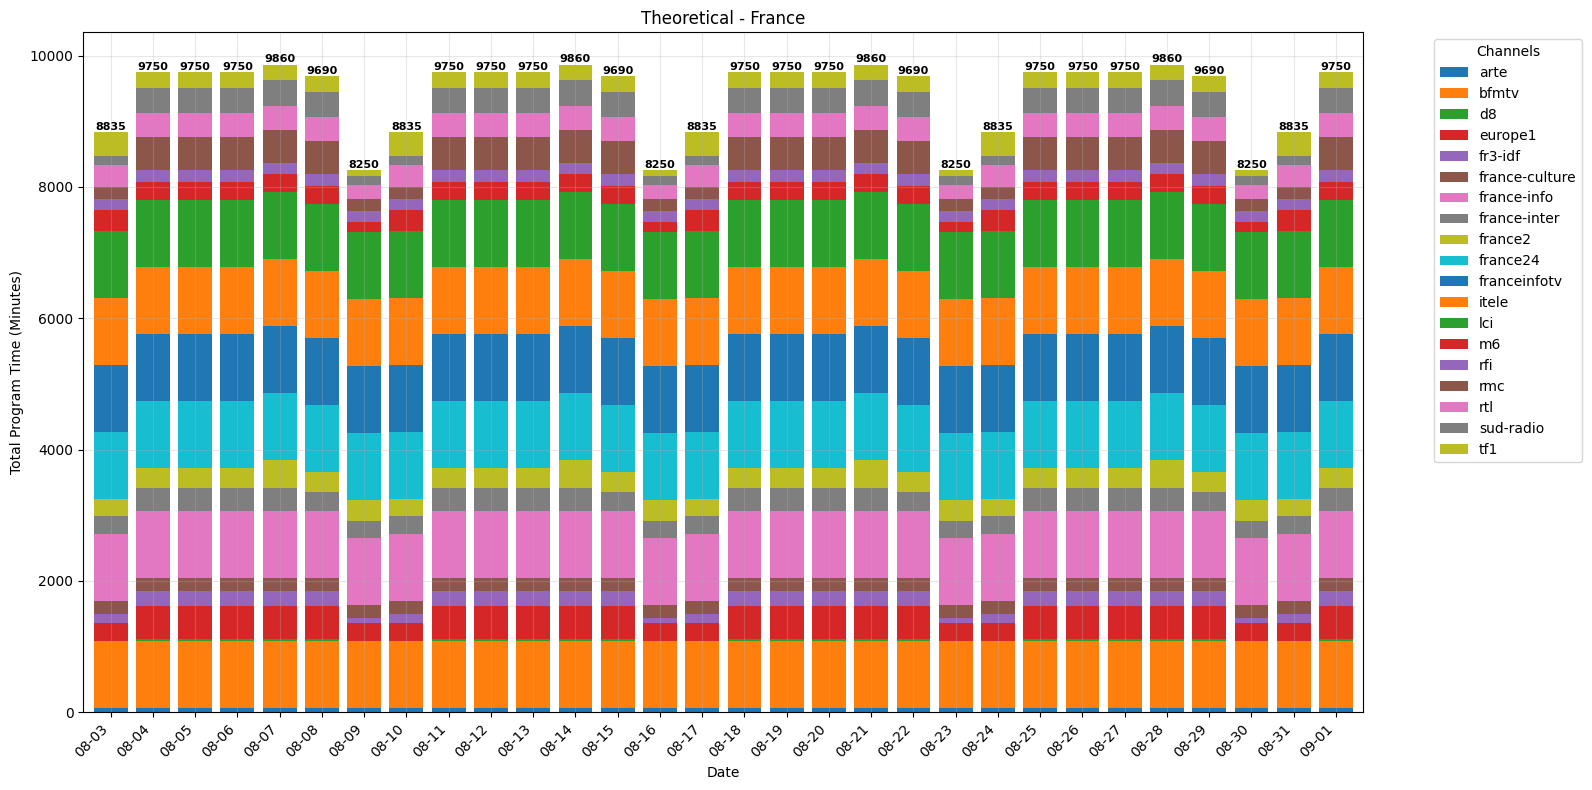

Stacked bar chart created successfully!
Data covers 30 days from 2025-08-03 to 2025-09-01
Channels included: ['arte', 'bfmtv', 'd8', 'europe1', 'fr3-idf', 'france-culture', 'france-info', 'france-inter', 'france2', 'france24', 'franceinfotv', 'itele', 'lci', 'm6', 'rfi', 'rmc', 'rtl', 'sud-radio', 'tf1']


channel_name,arte,bfmtv,d8,europe1,fr3-idf,france-culture,france-info,france-inter,france2,france24,franceinfotv,itele,lci,m6,rfi,rmc,rtl,sud-radio,tf1
2025-08-03,65.0,1020.0,NaN,270.0,150.0,190.0,1020.0,270.0,270.0,1020.0,1020.0,1020.0,1020.0,315.0,170.0,180.0,330.0,140.0,365.0
2025-08-04,65.0,1020.0,30.0,510.0,225.0,190.0,1020.0,360.0,305.0,1020.0,1020.0,1020.0,1020.0,275.0,170.0,510.0,360.0,390.0,240.0
2025-08-05,65.0,1020.0,30.0,510.0,225.0,190.0,1020.0,360.0,305.0,1020.0,1020.0,1020.0,1020.0,275.0,170.0,510.0,360.0,390.0,240.0
2025-08-06,65.0,1020.0,30.0,510.0,225.0,190.0,1020.0,360.0,305.0,1020.0,1020.0,1020.0,1020.0,275.0,170.0,510.0,360.0,390.0,240.0
2025-08-07,65.0,1020.0,30.0,510.0,225.0,190.0,1020.0,360.0,415.0,1020.0,1020.0,1020.0,1020.0,275.0,170.0,510.0,360.0,390.0,240.0


In [191]:
result_df_france_stacked = plot_stacked_channel_programs_from_dataframe_with_totals(result_df_france, title="Theoretical - France")
result_df_france_stacked.head()

<Figure size 1600x800 with 0 Axes>

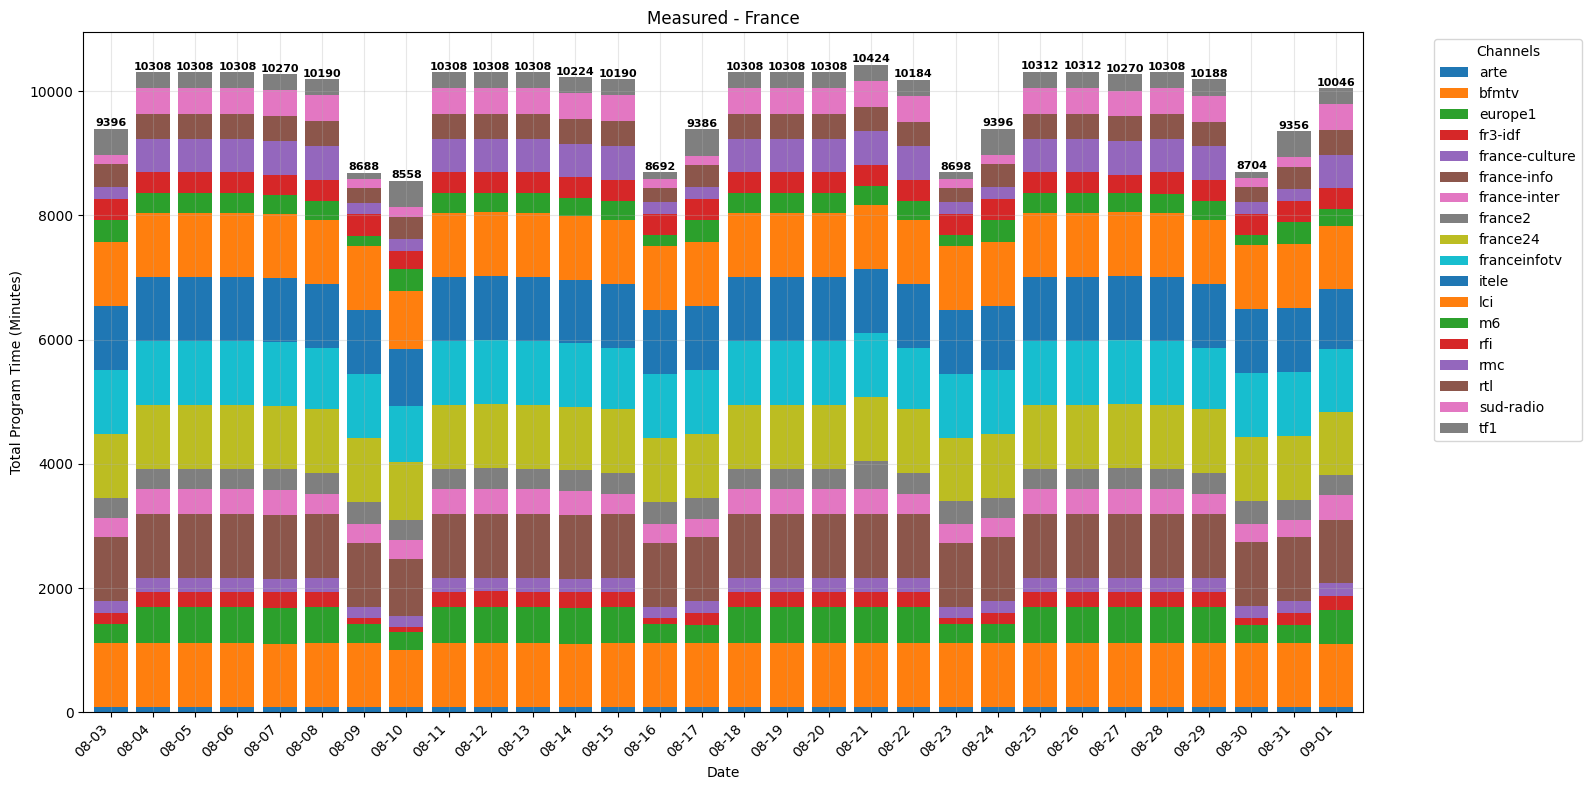

Stacked bar chart created successfully!
Data covers 30 days from 2025-08-03 to 2025-09-01
Channels included: ['arte', 'bfmtv', 'europe1', 'fr3-idf', 'france-culture', 'france-info', 'france-inter', 'france2', 'france24', 'franceinfotv', 'itele', 'lci', 'm6', 'rfi', 'rmc', 'rtl', 'sud-radio', 'tf1']


channel_name,arte,bfmtv,europe1,fr3-idf,france-culture,france-info,france-inter,france2,france24,franceinfotv,itele,lci,m6,rfi,rmc,rtl,sud-radio,tf1
2025-08-03,88,1028,300,190,188,1028,300,332,1030,1028,1030,1030,356,340,190,360,150,428
2025-08-04,84,1030,578,250,218,1030,400,334,1030,1030,1030,1030,310,340,540,400,416,258
2025-08-05,84,1030,578,250,218,1030,400,334,1030,1030,1030,1030,310,340,540,400,416,258
2025-08-06,84,1030,578,250,218,1030,400,334,1030,1030,1030,1030,310,340,540,400,416,258
2025-08-07,84,1024,578,250,218,1026,400,334,1024,1024,1026,1026,306,336,540,400,416,258


In [192]:
df_france_grouped_stacked = plot_stacked_channel_programs_from_dataframe_with_totals(df_france_grouped.reset_index(), "total_sum_minutes", title="Measured - France")
df_france_grouped_stacked.head()

<Figure size 1600x800 with 0 Axes>

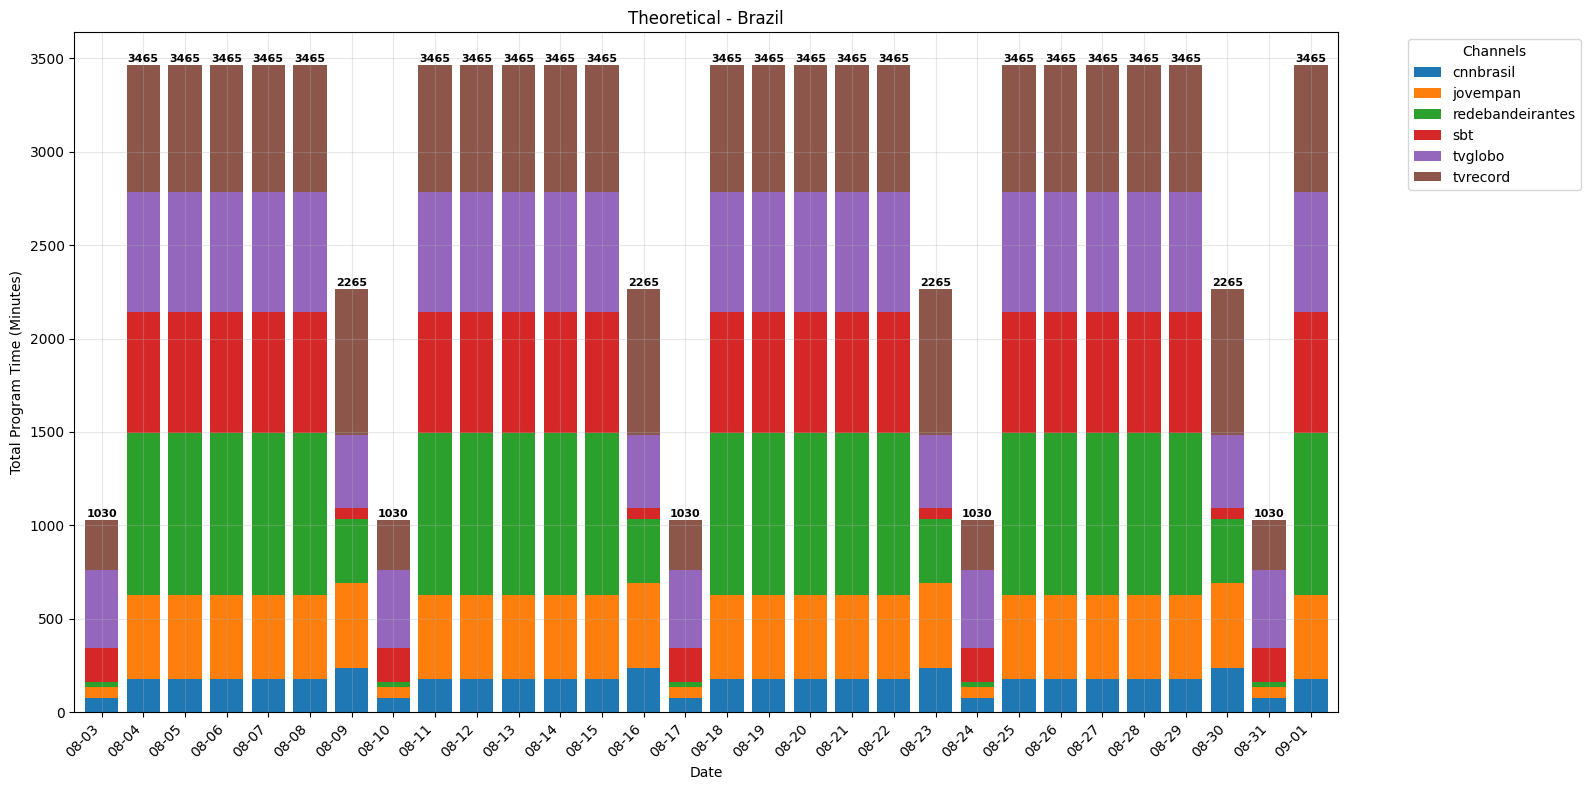

Stacked bar chart created successfully!
Data covers 30 days from 2025-08-03 to 2025-09-01
Channels included: ['cnnbrasil', 'jovempan', 'redebandeirantes', 'sbt', 'tvglobo', 'tvrecord']


channel_name,cnnbrasil,jovempan,redebandeirantes,sbt,tvglobo,tvrecord
2025-08-03,75.0,60.0,30.0,180.0,415.0,270.0
2025-08-04,180.0,450.0,865.0,645.0,645.0,680.0
2025-08-05,180.0,450.0,865.0,645.0,645.0,680.0
2025-08-06,180.0,450.0,865.0,645.0,645.0,680.0
2025-08-07,180.0,450.0,865.0,645.0,645.0,680.0


In [193]:
result_df_brazil_stacked = plot_stacked_channel_programs_from_dataframe_with_totals(result_df_brazil, title="Theoretical - Brazil")
result_df_brazil_stacked.head()

<Figure size 1600x800 with 0 Axes>

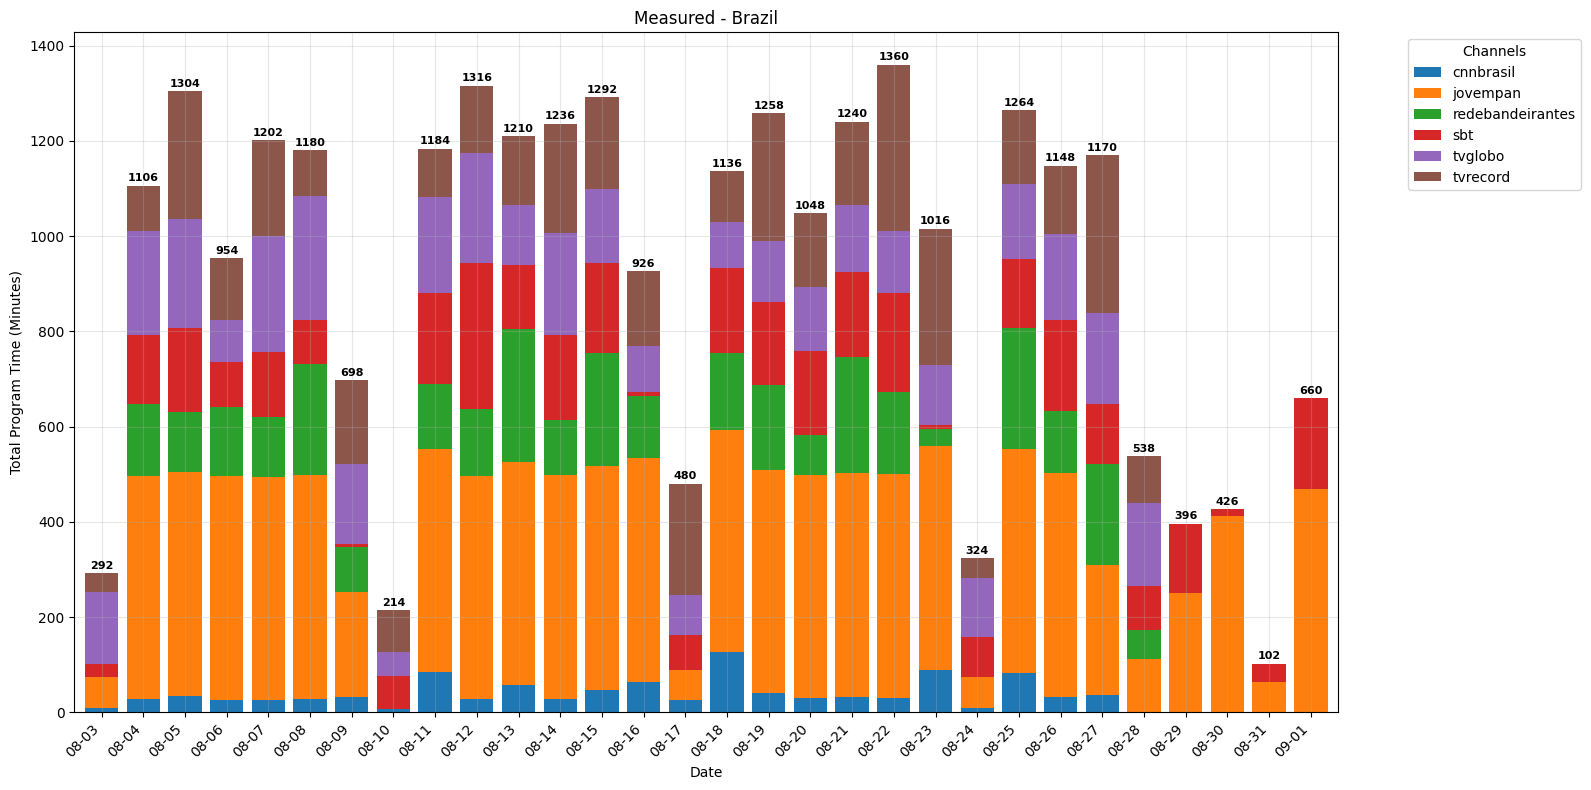

Stacked bar chart created successfully!
Data covers 30 days from 2025-08-03 to 2025-09-01
Channels included: ['cnnbrasil', 'jovempan', 'redebandeirantes', 'sbt', 'tvglobo', 'tvrecord']


channel_name,cnnbrasil,jovempan,redebandeirantes,sbt,tvglobo,tvrecord
2025-08-03,10.0,64.0,NaN,28.0,150.0,40.0
2025-08-04,28.0,468.0,152.0,144.0,218.0,96.0
2025-08-05,34.0,470.0,126.0,178.0,228.0,268.0
2025-08-06,26.0,470.0,146.0,94.0,88.0,130.0
2025-08-07,26.0,468.0,126.0,136.0,244.0,202.0


In [194]:
df_brazil_grouped_stacked = plot_stacked_channel_programs_from_dataframe_with_totals(df_brazil_grouped.reset_index(), "total_sum_minutes", title="Measured - Brazil")
df_brazil_grouped_stacked.head()

<Figure size 1600x800 with 0 Axes>

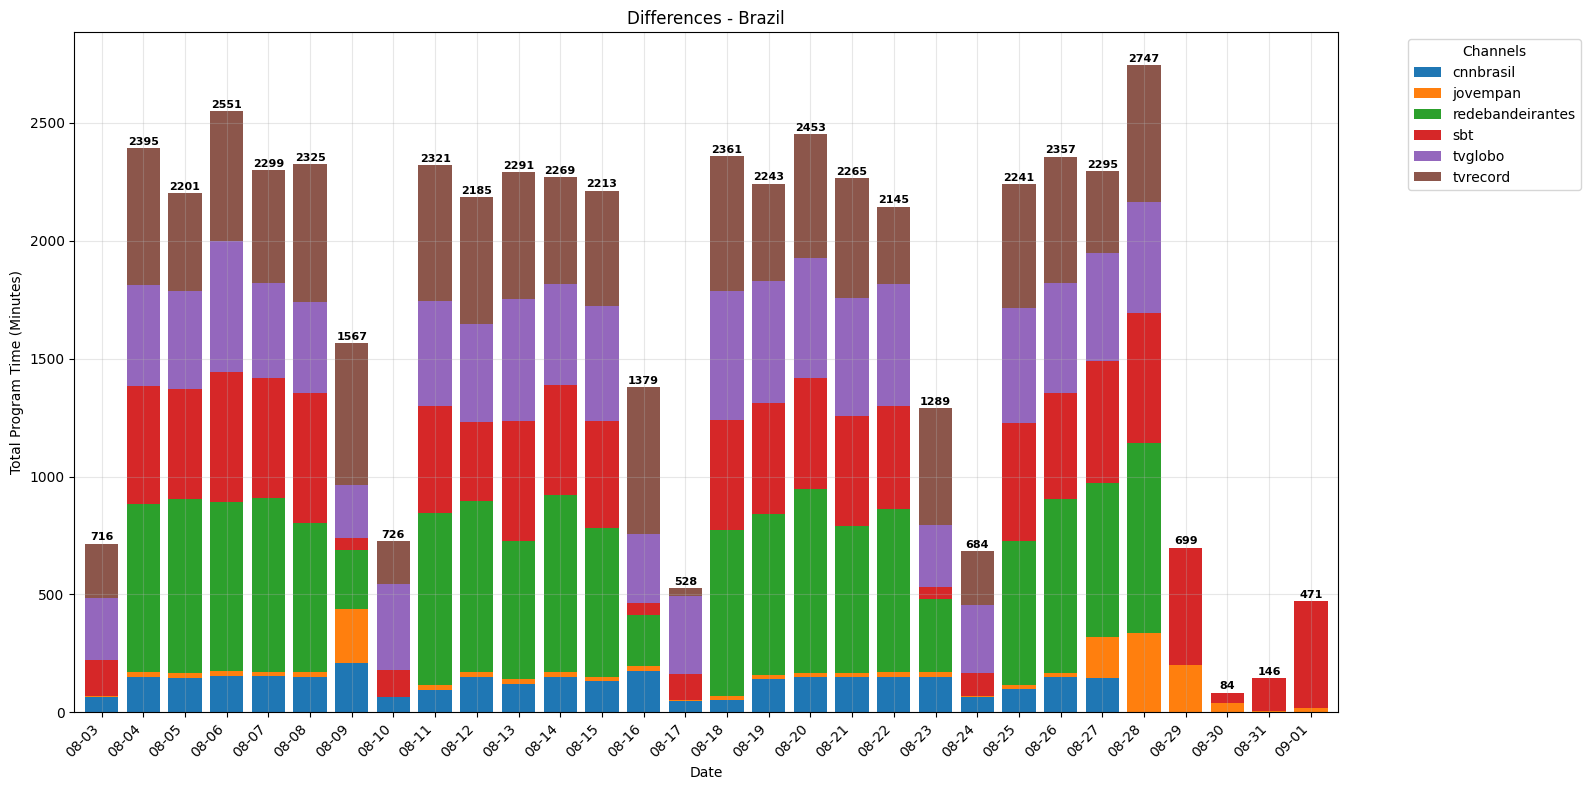

In [195]:
bar_plot_pivot_data((df_brazil_grouped_stacked - result_df_brazil_stacked).abs().fillna(0), title="Differences - Brazil")

<Figure size 1600x800 with 0 Axes>

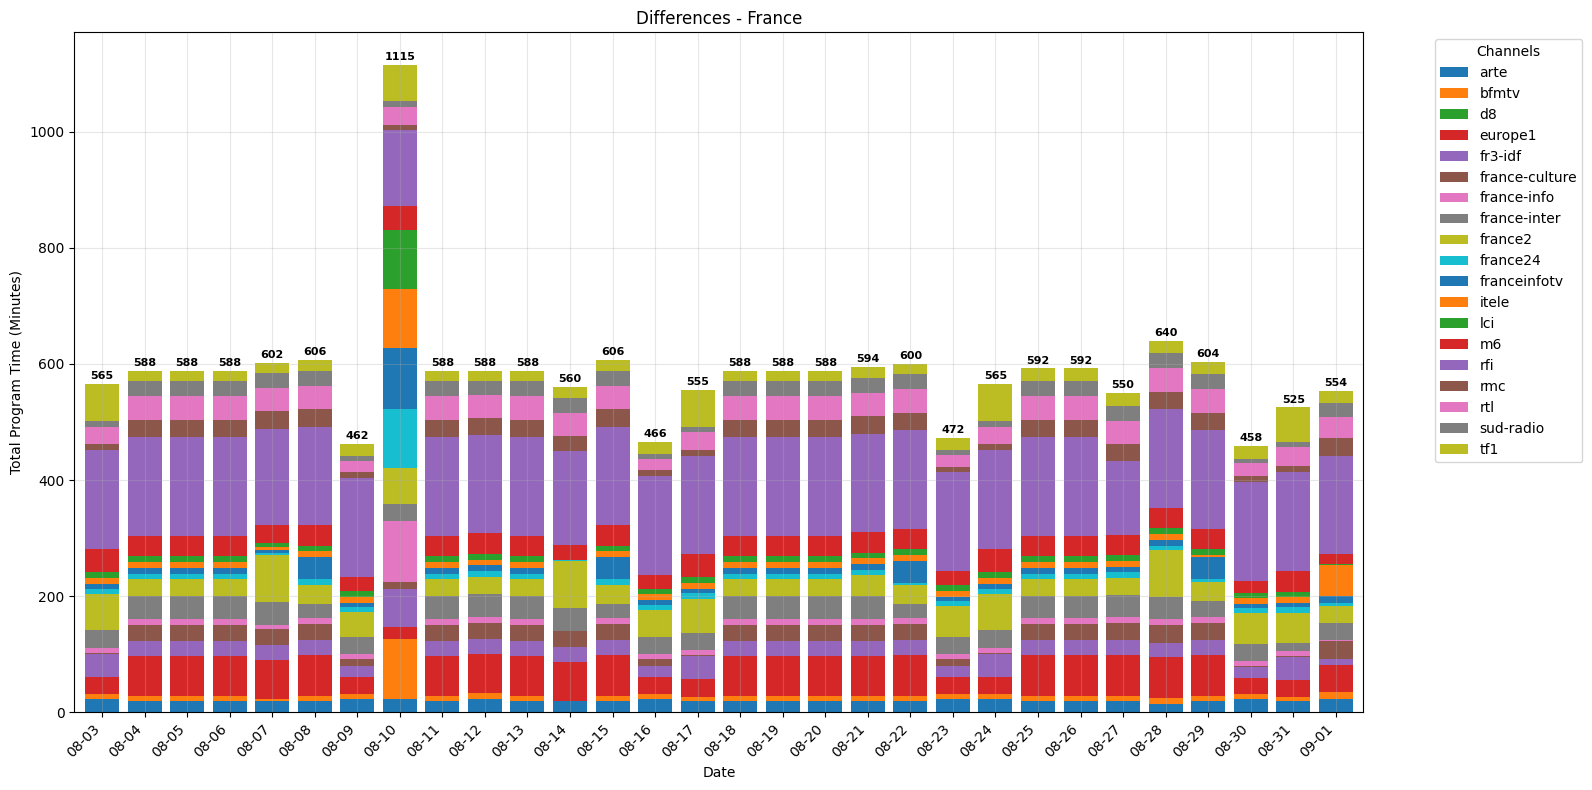

In [196]:
bar_plot_pivot_data((df_france_grouped_stacked - result_df_france_stacked).abs().fillna(0), title="Differences - France")

In [185]:
df_brazil_prod = load_parquet_files_from_scaleway_s3(
    bucket_name="mediatree", prefix="year=2025/month=8", region=REGION, country="brazil"
)

Found 168 parquet files:
  - mediatree/country=brazil/year=2025/month=8/day=1/channel=cnnbrasil/62a92c53b30e4f67985c47cb9ed8fa02-0.parquet
  - mediatree/country=brazil/year=2025/month=8/day=1/channel=jovempan/52fa137c47b74b9aa82b9b01ba7af369-0.parquet
  - mediatree/country=brazil/year=2025/month=8/day=1/channel=redebandeirantes/971e83c88b544d0aa165d4e234a017c5-0.parquet
  - mediatree/country=brazil/year=2025/month=8/day=1/channel=sbt/f3a6b20a91f84c08abae4325c4647d23-0.parquet
  - mediatree/country=brazil/year=2025/month=8/day=1/channel=tvglobo/da99427105984761845a1166c1630430-0.parquet
  - mediatree/country=brazil/year=2025/month=8/day=1/channel=tvrecord/7beaa4eb2520497b8e960011edcd4098-0.parquet
  - mediatree/country=brazil/year=2025/month=8/day=10/channel=cnnbrasil/9e822e9b7b9a488db102750f9c1030f6-0.parquet
  - mediatree/country=brazil/year=2025/month=8/day=10/channel=sbt/bd21def910804cdc923ed991ecba73b0-0.parquet
  - mediatree/country=brazil/year=2025/month=8/day=10/channel=tvglobo/

In [186]:
df_brazil_prod

,plaintext,srt,channel_name,channel_title,channel_radio,start,channel_program,channel_program_type,program_metadata_id
0,A unidade de ajuda humanitária e os palestinos...,"[{'cts_in_ms': 1754089320000, 'duration_ms': 2...",cnnbrasil,CNN Brasil,False,2025-08-01 20:02:00-03:00,,,d87ea31dc914bb18e69f1a2037f7037eab7da7cd85ef4c...
1,"Então avisando, dizendo que Lula pode conversa...","[{'cts_in_ms': 1754089440000, 'duration_ms': 3...",cnnbrasil,CNN Brasil,False,2025-08-01 20:04:00-03:00,,,d87ea31dc914bb18e69f1a2037f7037eab7da7cd85ef4c...
2,E tem que se perguntar qual é o cabimento diss...,"[{'cts_in_ms': 1754033160000, 'duration_ms': 2...",jovempan,Jovem Pan,False,2025-08-01 04:26:00-03:00,,,ed4622c67c205c073bbf25abd951342c213408fde4802c...
3,"Quem vai lá na frente determinar a condenação,...","[{'cts_in_ms': 1754033400000, 'duration_ms': 1...",jovempan,Jovem Pan,False,2025-08-01 04:30:00-03:00,,,ed4622c67c205c073bbf25abd951342c213408fde4802c...
4,Ajuda -se. É uma sentença já predeterminada co...,"[{'cts_in_ms': 1754033520000, 'duration_ms': 3...",jovempan,Jovem Pan,False,2025-08-01 04:32:00-03:00,,,ed4622c67c205c073bbf25abd951342c213408fde4802c...
...,...,...,...,...,...,...,...,...,...
13358,Por que fiz isso com meu filho? Ele queria mat...,"[{'cts_in_ms': 1754779440000, 'duration_ms': 1...",tvrecord,TV Record,False,2025-08-09 19:44:00-03:00,,,4c6d5e6c3882fcacc1bc5ce3f5ed67b666cb8b05989317...
13359,"um vizinho que também mora aqui, vem cá Dona A...","[{'cts_in_ms': 1754779323040, 'duration_ms': 8...",tvrecord,TV Record,False,2025-08-09 19:42:00-03:00,,,4c6d5e6c3882fcacc1bc5ce3f5ed67b666cb8b05989317...
13360,"1 de fevereiro, no dia 2 de fevereiro, no dia ...","[{'cts_in_ms': 1754779575660, 'duration_ms': 0...",tvrecord,TV Record,False,2025-08-09 19:46:00-03:00,,,4c6d5e6c3882fcacc1bc5ce3f5ed67b666cb8b05989317...
13361,E depois sobra para quem pagar. Para nós pagar...,"[{'cts_in_ms': 1754779710000, 'duration_ms': 1...",tvrecord,TV Record,False,2025-08-09 19:48:00-03:00,,,4c6d5e6c3882fcacc1bc5ce3f5ed67b666cb8b05989317...


In [187]:
df_brazil_prod["duration"] = 2
df_brazil_prod["date"] = pd.to_datetime(df_brazil_prod.start).dt.date
df_brazil_prod_grouped = df_brazil_prod.groupby(["date", "channel_name"]).agg(
    total_sum_minutes=("duration", sum)
)

/var/folders/_y/jjyv0bm5597_x15dvpxnsmrc0000gn/T/ipykernel_65673/2512140750.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_brazil_prod_grouped = df_brazil_prod.groupby(["date", "channel_name"]).agg(


<Figure size 1600x800 with 0 Axes>

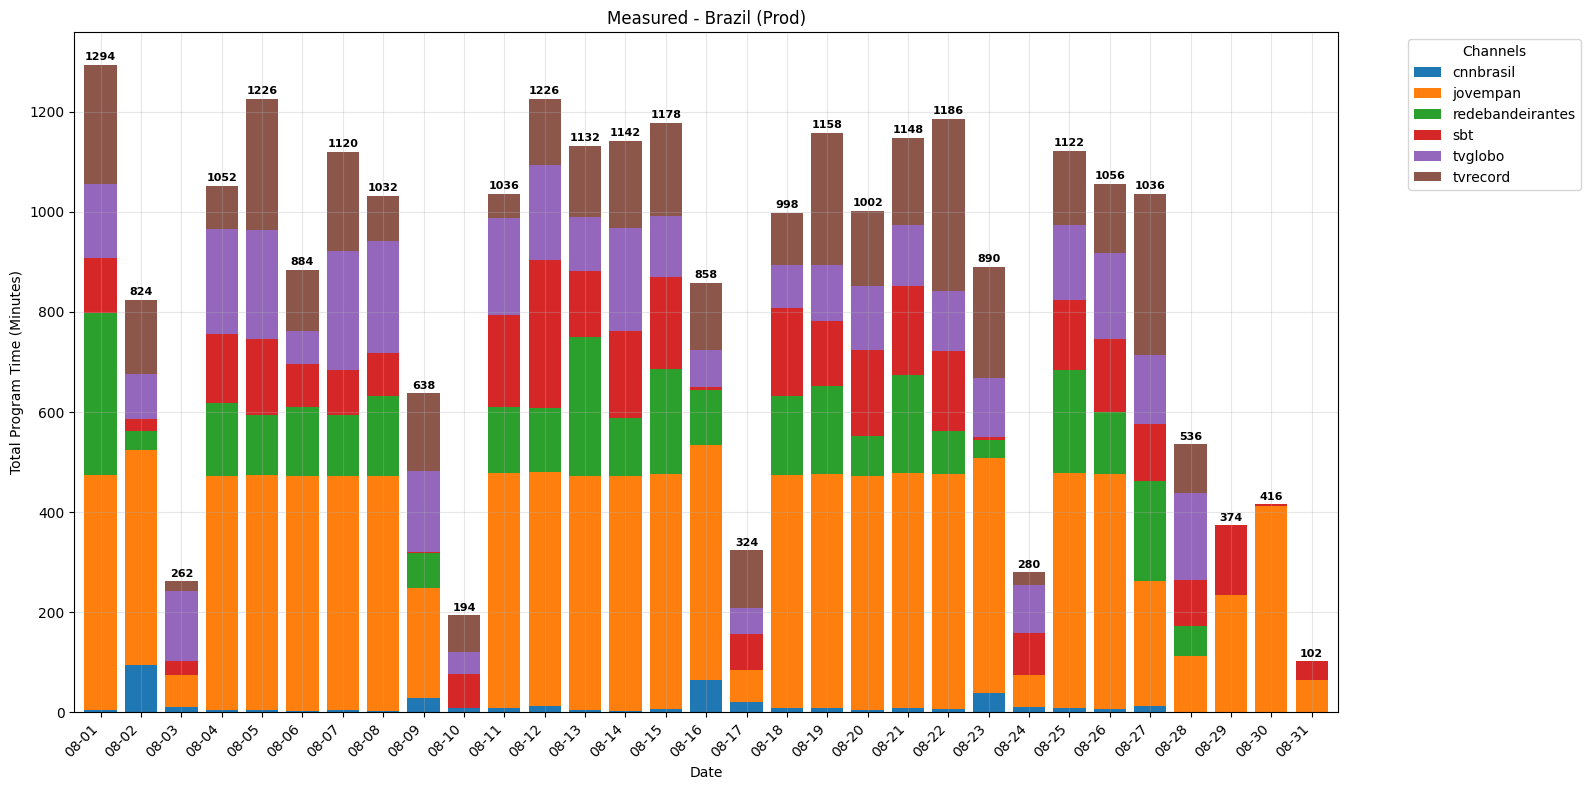

Stacked bar chart created successfully!
Data covers 31 days from 2025-08-01 to 2025-08-31
Channels included: ['cnnbrasil', 'jovempan', 'redebandeirantes', 'sbt', 'tvglobo', 'tvrecord']


In [198]:
df_brazil_prod_grouped_stacked = plot_stacked_channel_programs_from_dataframe_with_totals(df_brazil_prod_grouped.reset_index(), "total_sum_minutes", title="Measured - Brazil (Prod)")


<Figure size 1600x800 with 0 Axes>

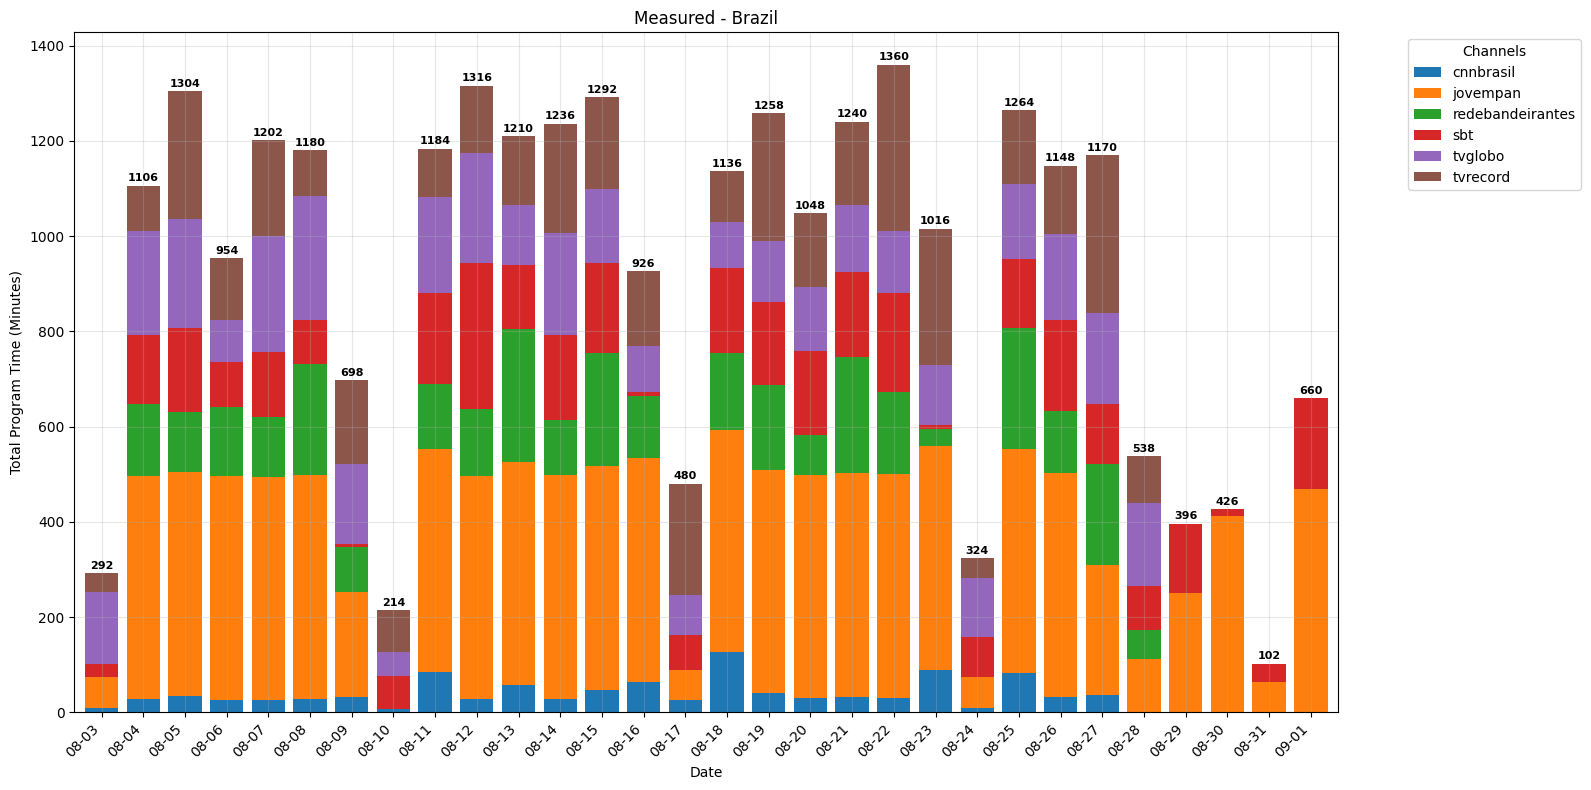

Stacked bar chart created successfully!
Data covers 30 days from 2025-08-03 to 2025-09-01
Channels included: ['cnnbrasil', 'jovempan', 'redebandeirantes', 'sbt', 'tvglobo', 'tvrecord']


channel_name,cnnbrasil,jovempan,redebandeirantes,sbt,tvglobo,tvrecord
2025-08-03,10.0,64.0,NaN,28.0,150.0,40.0
2025-08-04,28.0,468.0,152.0,144.0,218.0,96.0
2025-08-05,34.0,470.0,126.0,178.0,228.0,268.0
2025-08-06,26.0,470.0,146.0,94.0,88.0,130.0
2025-08-07,26.0,468.0,126.0,136.0,244.0,202.0
2025-08-08,28.0,470.0,234.0,92.0,260.0,96.0
2025-08-09,32.0,220.0,96.0,6.0,168.0,176.0
2025-08-10,8.0,NaN,NaN,68.0,50.0,88.0
2025-08-11,84.0,470.0,136.0,190.0,202.0,102.0
2025-08-12,28.0,468.0,140.0,308.0,230.0,142.0


In [197]:
plot_stacked_channel_programs_from_dataframe_with_totals(df_brazil_grouped.reset_index(), "total_sum_minutes", title="Measured - Brazil")

In [ ]:
df_brazil_grouped_merged = df_brazil_grouped.merge(
    df_brazil_prod_grouped,
    how='outer',
    left_index=True,
    right_index=True,
    suffixes=["_test", "_prod"]
).reset_index()
df_brazil_grouped_merged = df_brazil_grouped_merged.loc[(pd.to_datetime(df_brazil_grouped_merged.date).dt.month==8) & (pd.to_datetime(df_brazil_grouped_merged.date).dt.day>2)]
df_brazil_grouped_merged["diff"] = df_brazil_grouped_merged.total_sum_minutes_test - df_brazil_grouped_merged.total_sum_minutes_prod
df_brazil_grouped_merged["perc_diff"] = df_brazil_grouped_merged.total_sum_minutes_test - df_brazil_grouped_merged.total_sum_minutes_prod

<Figure size 1600x800 with 0 Axes>

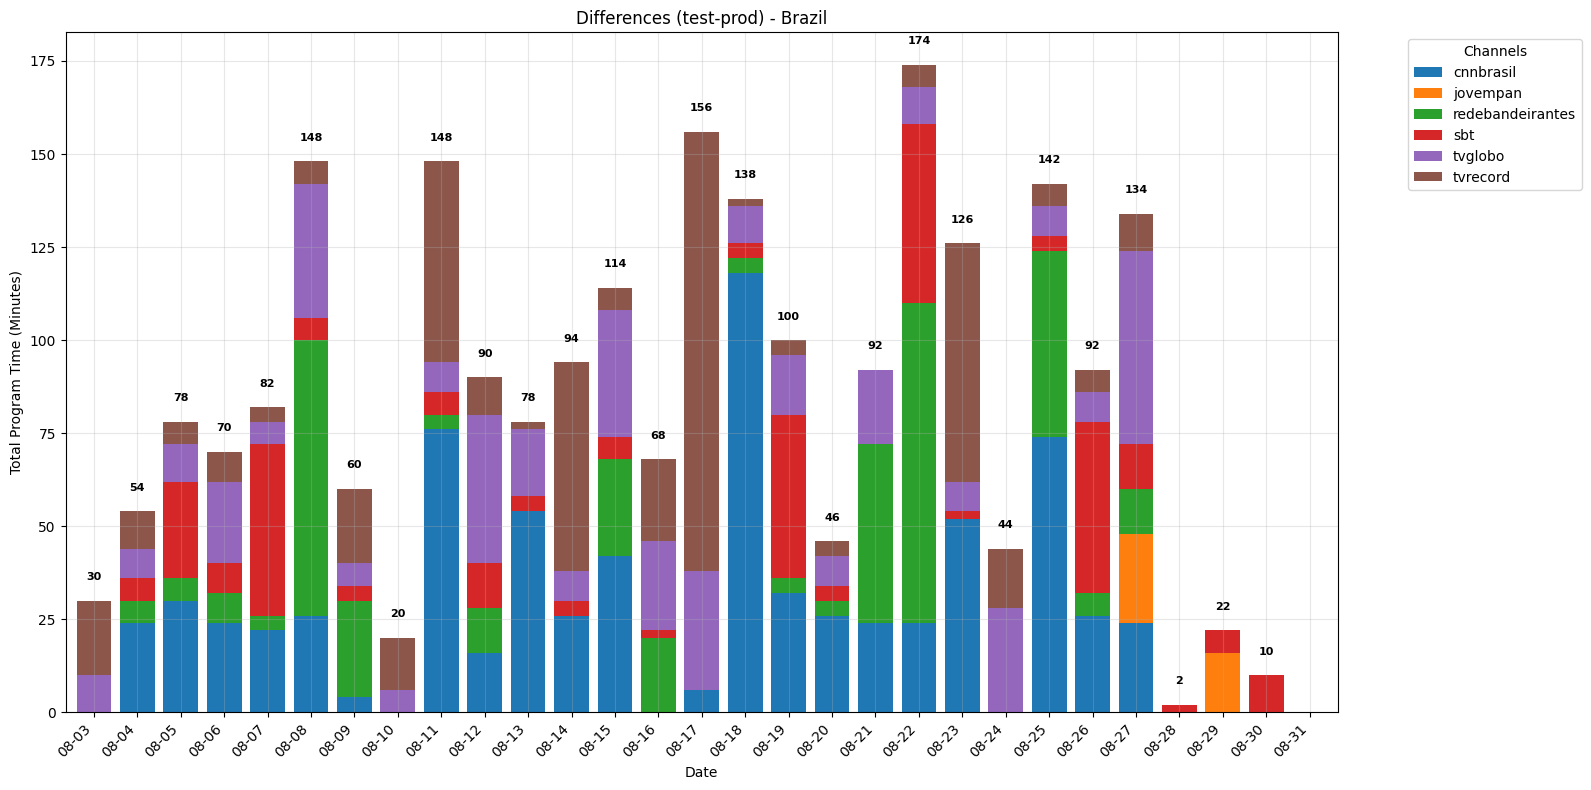

Stacked bar chart created successfully!
Data covers 29 days from 2025-08-03 to 2025-08-31
Channels included: ['cnnbrasil', 'jovempan', 'redebandeirantes', 'sbt', 'tvglobo', 'tvrecord']


channel_name,cnnbrasil,jovempan,redebandeirantes,sbt,tvglobo,tvrecord
2025-08-03,0.0,0.0,NaN,0.0,10.0,20.0
2025-08-04,24.0,0.0,6.0,6.0,8.0,10.0
2025-08-05,30.0,0.0,6.0,26.0,10.0,6.0
2025-08-06,24.0,0.0,8.0,8.0,22.0,8.0
2025-08-07,22.0,0.0,4.0,46.0,6.0,4.0
2025-08-08,26.0,0.0,74.0,6.0,36.0,6.0
2025-08-09,4.0,0.0,26.0,4.0,6.0,20.0
2025-08-10,0.0,NaN,NaN,0.0,6.0,14.0
2025-08-11,76.0,0.0,4.0,6.0,8.0,54.0
2025-08-12,16.0,0.0,12.0,12.0,40.0,10.0


In [219]:
plot_stacked_channel_programs_from_dataframe_with_totals(df_brazil_grouped_merged, "diff", title="Differences (test-prod) - Brazil")

In [215]:
df_france_prod = load_parquet_files_from_scaleway_s3(
    bucket_name="mediatree", prefix="year=2025/month=8", region=REGION, country="france"
)

Found 558 parquet files:
  - mediatree/year=2025/month=8/day=1/channel=arte/f0fad0222dca492c97e929c605d62e65-0.parquet
  - mediatree/year=2025/month=8/day=1/channel=bfmtv/9171662e6e4345c6af16054cf12bee6d-0.parquet
  - mediatree/year=2025/month=8/day=1/channel=europe1/7925171e303a47af9ae1bc678d7b7a1a-0.parquet
  - mediatree/year=2025/month=8/day=1/channel=fr3-idf/5495d546e2d141b2a267ae90161c6b59-0.parquet
  - mediatree/year=2025/month=8/day=1/channel=france-culture/365a1a6ba1e3453ba5de9f0ca30420a3-0.parquet
  - mediatree/year=2025/month=8/day=1/channel=france-info/f4dc97a8726e4ca690069b19d9d553bc-0.parquet
  - mediatree/year=2025/month=8/day=1/channel=france-inter/db4b879dc74345f8a99595c15e8f93f9-0.parquet
  - mediatree/year=2025/month=8/day=1/channel=france2/7f108dfbc01247c1ae9900dde3b19cf4-0.parquet
  - mediatree/year=2025/month=8/day=1/channel=france24/3669763509ea4e9e8df491ad82a40905-0.parquet
  - mediatree/year=2025/month=8/day=1/channel=franceinfotv/4a28a7c1757d4e83bf76a99a6ee74a1

In [216]:
df_france_prod["duration"] = 2
df_france_prod["date"] = pd.to_datetime(df_france_prod.start).dt.date
df_france_prod_grouped = df_france_prod.groupby(["date", "channel_name"]).agg(
    total_sum_minutes=("duration", sum)
)

/var/folders/_y/jjyv0bm5597_x15dvpxnsmrc0000gn/T/ipykernel_65673/2920721051.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_france_prod_grouped = df_france_prod.groupby(["date", "channel_name"]).agg(


In [217]:
df_france_grouped_merged = df_france_grouped.merge(
    df_france_prod_grouped,
    how='outer',
    left_index=True,
    right_index=True,
    suffixes=["_test", "_prod"]
).reset_index()
df_france_grouped_merged = df_france_grouped_merged.loc[(pd.to_datetime(df_france_grouped_merged.date).dt.month==8) & (pd.to_datetime(df_france_grouped_merged.date).dt.day>2)]
df_france_grouped_merged["diff"] = df_france_grouped_merged.total_sum_minutes_test - df_france_grouped_merged.total_sum_minutes_prod

<Figure size 1600x800 with 0 Axes>

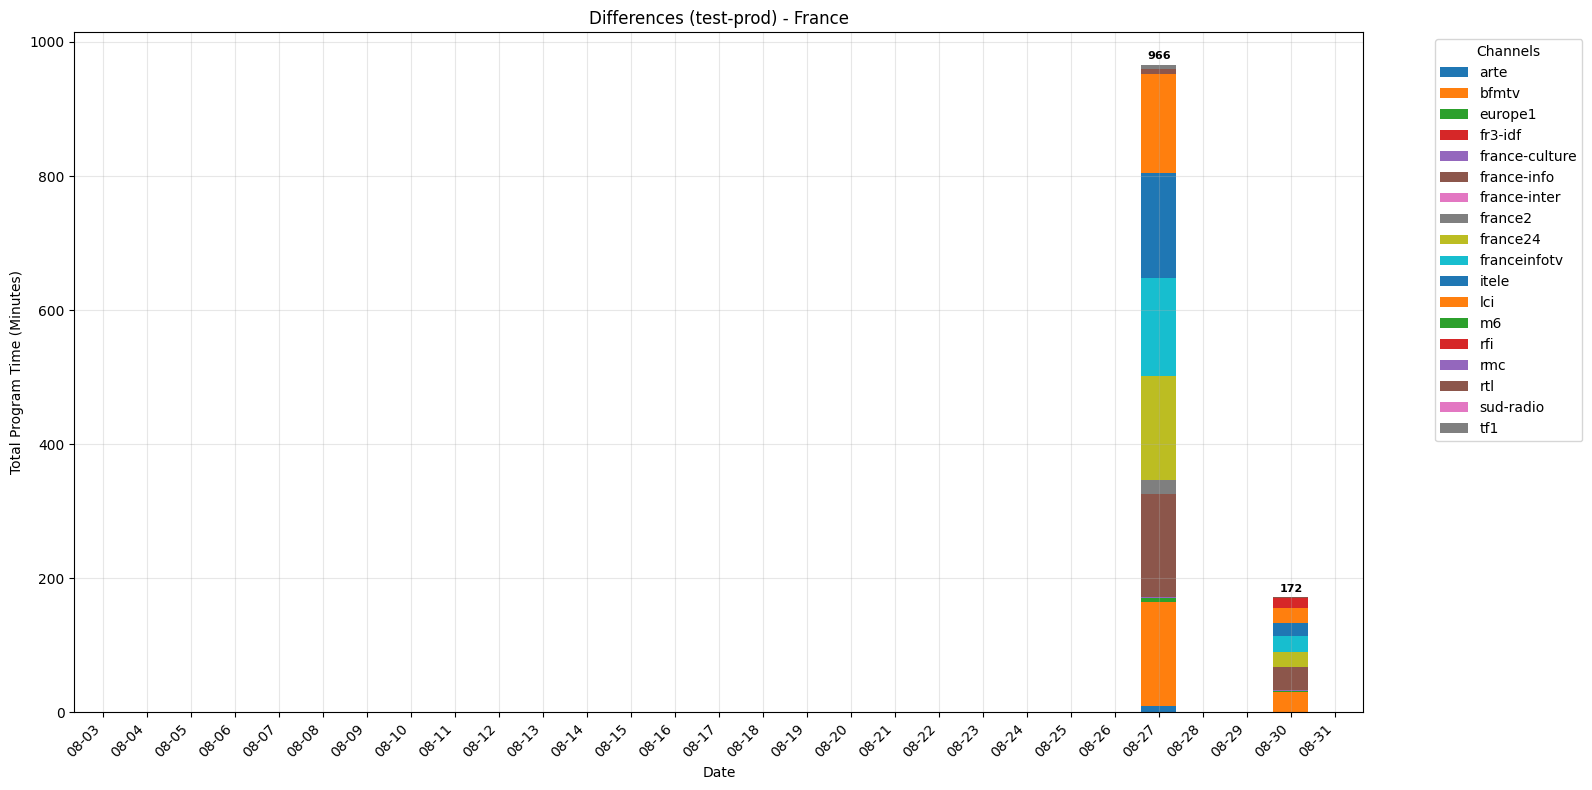

Stacked bar chart created successfully!
Data covers 29 days from 2025-08-03 to 2025-08-31
Channels included: ['arte', 'bfmtv', 'europe1', 'fr3-idf', 'france-culture', 'france-info', 'france-inter', 'france2', 'france24', 'franceinfotv', 'itele', 'lci', 'm6', 'rfi', 'rmc', 'rtl', 'sud-radio', 'tf1']


channel_name,arte,bfmtv,europe1,fr3-idf,france-culture,france-info,france-inter,france2,france24,franceinfotv,itele,lci,m6,rfi,rmc,rtl,sud-radio,tf1
2025-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-08-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-08-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-08-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-08-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-08-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-08-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-08-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
plot_stacked_channel_programs_from_dataframe_with_totals(df_france_grouped_merged, "diff", title="Differences (test-prod) - France")